[go/customer-churn-code](go/customer-churn-code)

# Introduction

This is an exercise to predict customer churn. I will test:

1.   Linear regression algorithm. I will build a model in the BigQuery UI, and I will connect Looker to it to show the results.
2.   Linear regression model. This time I will run iPython code from a AI Platform Notebook, and I will make charts in it.
3.   KNN (K-Nearest Neighbors) algorithm in Python as well.

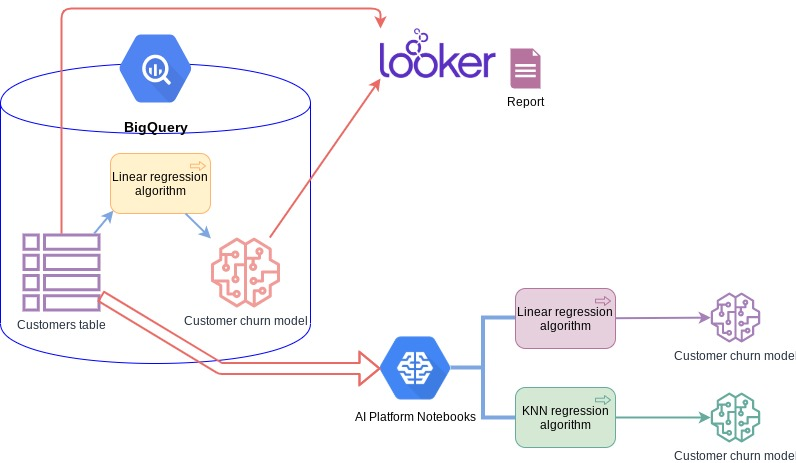



The data set contains information of customers to a telco company.

The data set includes information about:
*   Customers who left within the last month – the column is called Churn.
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies.
*   Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges.
*   Demographic info about customers – gender, age range, and if they have partners and dependents.

I took the data set from [here](https://www.kaggle.com/blastchar/telco-customer-churn).

# Prepare data to work

I [created a dataset](https://cloud.google.com/bigquery/docs/datasets#create-dataset) called vanilla in my BigQuery project and I set it in the European Union.

Then I [uploaded the customer information](https://cloud.google.com/bigquery/docs/loading-data-local) in the [CSV file](https://www.kaggle.com/blastchar/telco-customer-churn) into my dataset. I did it from the BigQuery console, and I enabled schema auto-detectation.

I could have saved the [CSV file](https://www.kaggle.com/blastchar/telco-customer-churn) in a [Cloud Storage bucket](https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv#loading_csv_data_into_a_table) and upload it from there.

# Set up project variables

I will use next variables in the next sections.

In [ ]:
customer_info = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
my_project_id = 'celiamuriel-demo'
my_dataset = 'vanilla'
my_customers_table = 'customers_colab'

# If I wanted to load the data from a file into Colab

I loaded the information in a data set called vanilla, in a table called "telco_customers", in BigQuery. I will connect this Còlab notebook to the telco_customers table to do this exercise.

If I wanted to load the data from a file in Colab to do the exercise, I'd do as follows.

In [ ]:
# Load the data 
from google.colab import files # Use to load data on Google Colab 
uploaded = files.upload() # Use to load data on Google Colab

Store the data into a data frame and print the first 7 rows of data.

In [ ]:
import pandas as pd
df = pd.read_csv(customer_info)
df.head(7)

FileNotFoundError: ignored

# Connect Colab notebook to BigQuery

The notebook [Getting started with BigQuery](https://colab.research.google.com/notebooks/bigquery.ipynb) shows how to connect with BigQuery, and the different forms to interact with it.

## Provide credentials to runtime

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Optional: Enable data table display

Colab includes the google.colab.data_table package that can be used to display large pandas dataframes as an interactive data table. It can be enabled as follows.

In [ ]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


If I wanted to return to the classic Pandas dataframe display, I could disable the large pandas dataframes as follows.

In [ ]:
%unload_ext google.colab.data_table

# Predict customer churn with a logistic regression model - BigQuery UI

## Preparation

I create a dataset called vanilla in my BigQuery project. As I am going to work from Spain, I create the data set in the European Union and I run my queries from there.

Convert all boolean fields in equivalent number fields.

```
create or replace table vanilla.customers_logreg
as
select customerID
     , gender
     , SeniorCitizen
     , Partner
     , case
           when Partner is True then 1
           else 0
       end as Partner_num
     , Dependents
     , case
           when Dependents is True then 1
           else 0
       end as Dependents_num
     , tenure
     , PhoneService
     , case
           when PhoneService is True then 1
           else 0
       end as PhoneService_num
     , MultipleLines
     , InternetService
     , OnlineSecurity
     , OnlineBackup
     , DeviceProtection
     , TechSupport
     , StreamingTV
     , StreamingMovies
     , Contract
     , PaperlessBilling
     , case
           when PaperlessBilling is True then 1
           else 0
       end as PaperlessBilling_num
     , PaymentMethod
     , MonthlyCharges
     , cast ((case
                  when TotalCharges = ' ' then '0'
                  else TotalCharges
              end) as float64) as TotalCharges
     , Churn
     , case
           when Churn is True then 1
           else 0
       end as Churn_num
from vanilla.customers;
```

I loaded the [customer data](https://www.kaggle.com/blastchar/telco-customer-churn) I am going to predict customer churn in the table vanilla.customers.

## Create the model

I create the model.

```
# Provide name of model
create or replace model vanilla.customer_churn_test
# Specify options
options
       (model_type='linear_reg',
        input_label_cols=['Churn_num'])
as
# Provide training data
select gender
     , SeniorCitizen
     , tenure
     , TechSupport
     , Contract
     , MonthlyCharges
     , TotalCharges
     , Churn_num
from vanilla.customers_logreg
-- where Churn_num is not null # Filter for rows containing data we want to predict.
```



## Model inspection

I can see the information about the training, evaluation and schema of the model after creating it.

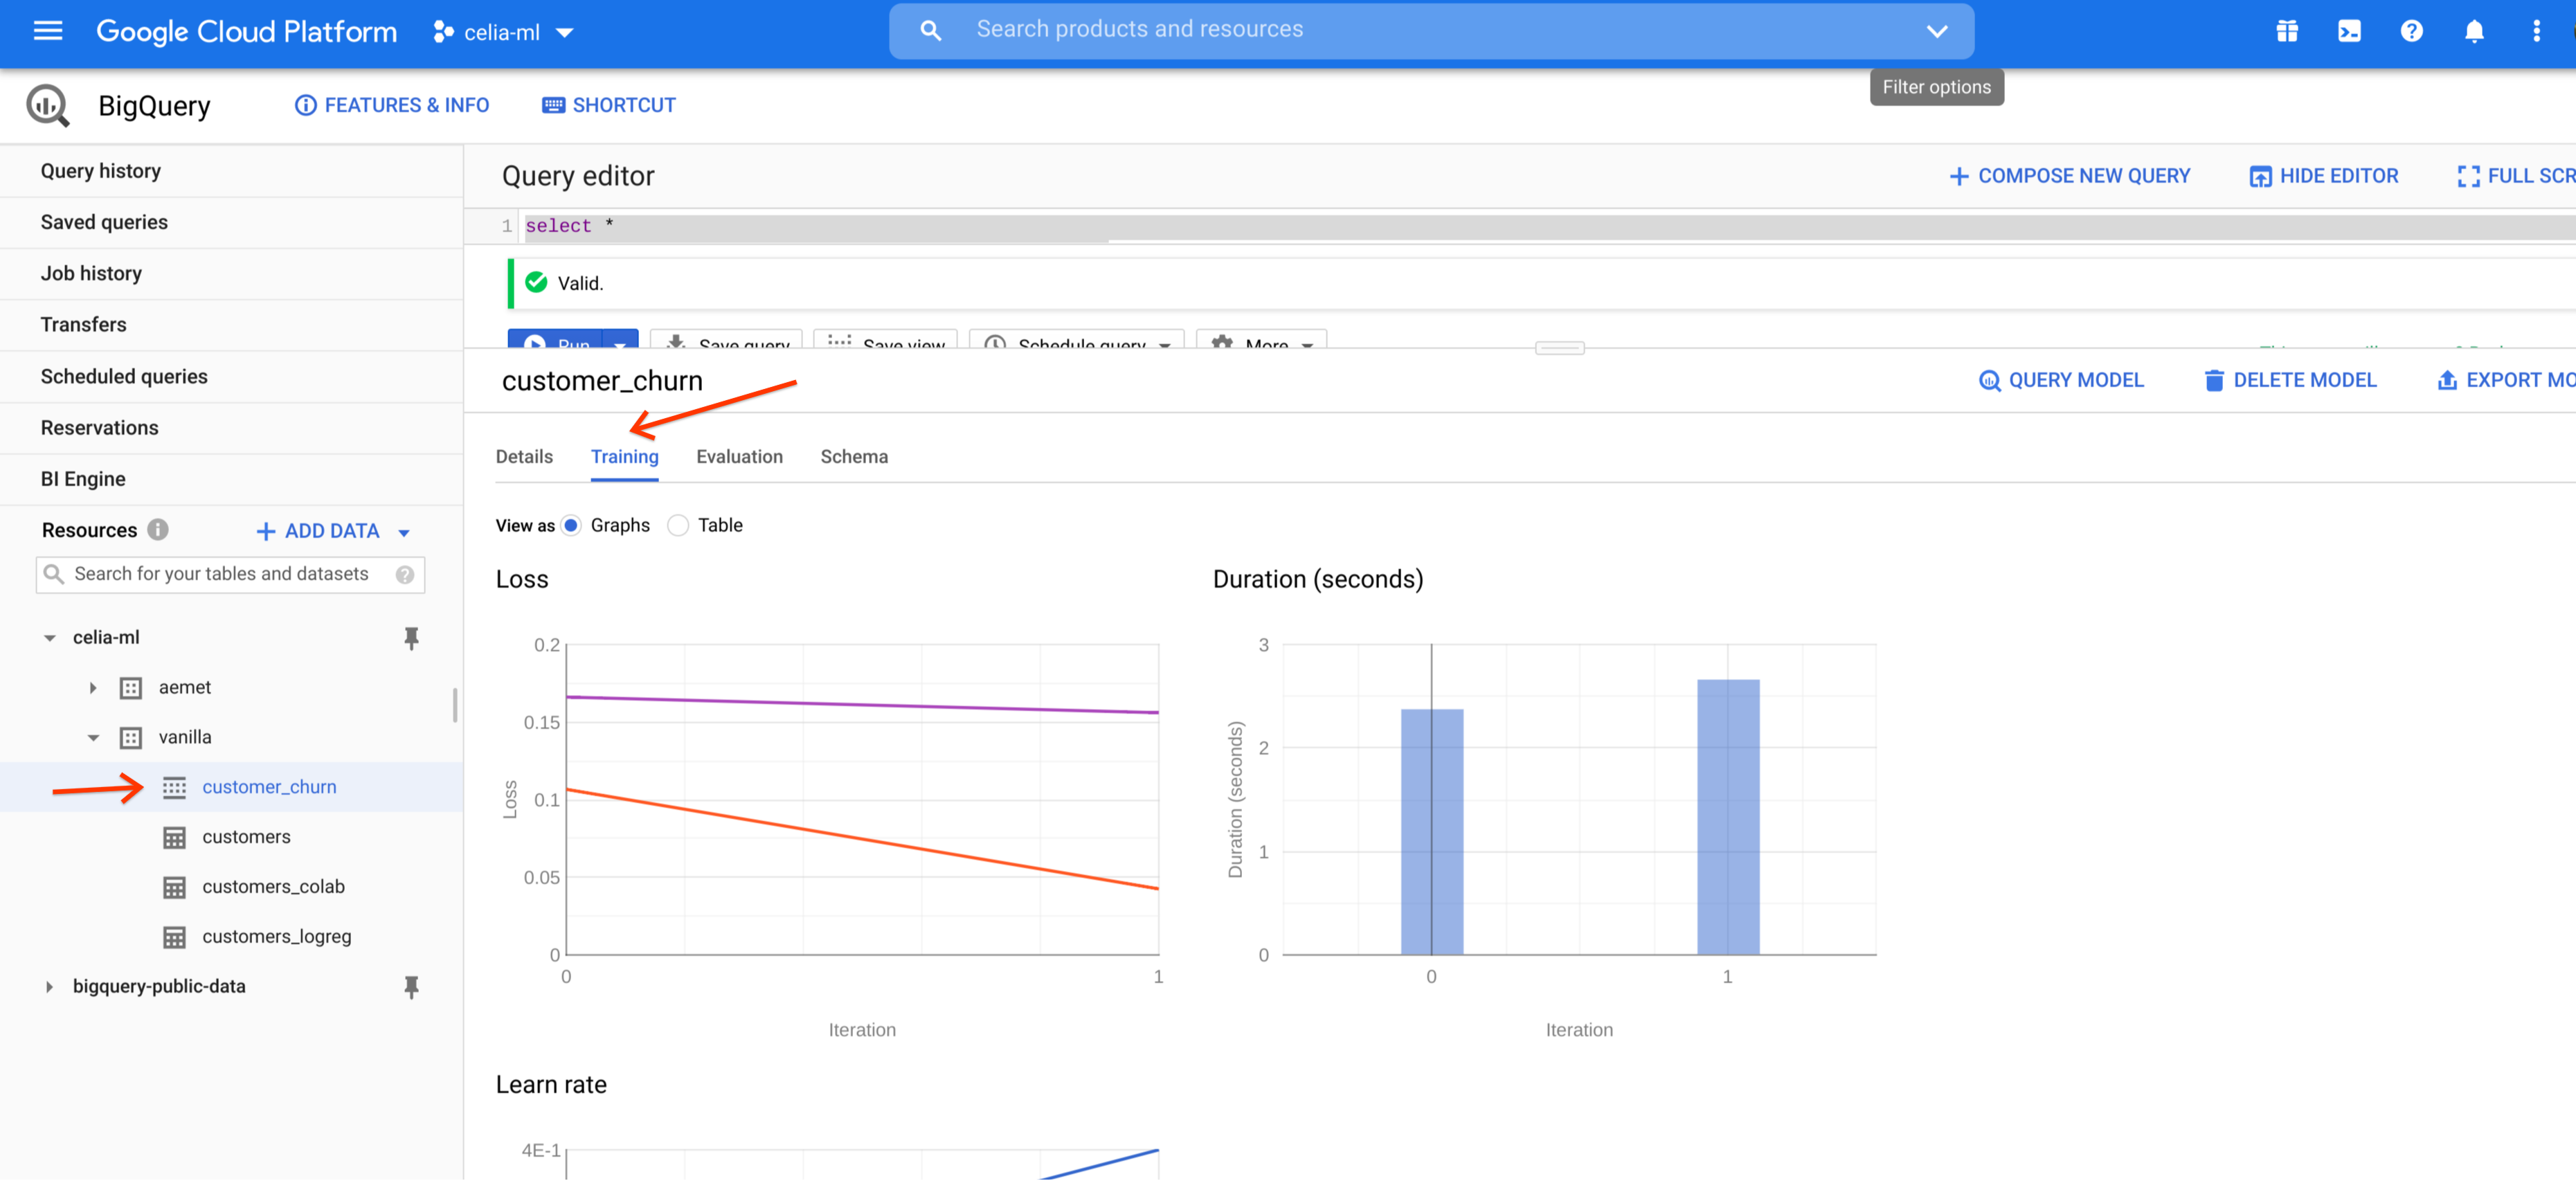

I can also run [ml.training_info](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train) function.

```
select *
from ml.training_info (model vanilla.customer_churn)
```



Other functions I can use for model and feature inspection - There are more funtions than shown here, which can be used depending on the model you are using.

[feature_info](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature)
```
select *
from ml.feature_info (model vanilla.customer_churn)
```

[weights](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-weights)
```
select *
from ml.weights (model vanilla.customer_churn)
```

Evaluation functions - there are more for other models.

[evaluate](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate)
```
select *
from ml.evaluate (model vanilla.customer_churn)
```

## Prediction

```
-- Table
select gender
     , SeniorCitizen
     , tenure
     , TechSupport
     , Contract
     , MonthlyCharges
     , TotalCharges
     , predicted_Churn_num
from ml.predict ( model vanilla.customer_churn
                , table vanilla.customers_logreg
                )

-- Query to create the model
select gender
     , SeniorCitizen
     , tenure
     , TechSupport
     , Contract
     , MonthlyCharges
     , TotalCharges
     , predicted_Churn_num
from ml.predict ( model vanilla.customer_churn
                , (select gender
                           , SeniorCitizen
                           , tenure
                           , TechSupport
                           , Contract
                           , MonthlyCharges
                           , TotalCharges
                           , Churn_num
                   from `vanilla.customers_logreg`
                  )
                )
```

# Predict customer churn with a logistic regression model - Colab notebook

I based this section on [this notebook](https://www.kaggle.com/akashdixit0905/telco-customer-churn-eda-visualization-dt-pca/notebook). I loaded the data in BigQuery, and work with it from my dataset, rather than load the data file into the Colab runtime.

I wrote this notebook on October 4th, 2020. Linear regression was already a [supported model in BigQuery ML](https://cloud.google.com/bigquery-ml/docs/introduction#supported_models_in).

## Initialise

Import libraries.

In [ ]:
import numpy as np #linear algebra
import pandas as pd #data processing
import os #import operating system
import matplotlib.pyplot as plt #matrixplot

from PIL import Image #image library
%matplotlib inline

import seaborn as sns #graph plotting
import itertools # Iterator

import warnings
warnings.filterwarnings("ignore")

import io #input-output operation (BYtesIO & StringIO)

import plotly.offline as py #interactibe Graphical
py.init_notebook_mode(connected = True)

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from google.cloud import bigquery

Use [BigQuery](https://cloud.google.com/bigquery/docs) through [google-cloud-bigquery](https://googleapis.dev/python/bigquery/latest/index.html).

Retrieve the customer data to operate.

In [ ]:
client = bigquery.Client(project = my_project_id)

query = """
select *
from """  + my_dataset + "." + my_customers_table + ";"

telcom = client.query(query).to_dataframe()

telcom.head()

customerID  gender  SeniorCitizen  ...  MonthlyCharges  TotalCharges  Churn
0  9732-OUYRN  Female              0  ...            19.0         918.7  False
1  0661-KQHNK  Female              0  ...            19.0         105.5  False
2  4709-LKHYG  Female              0  ...            20.0        540.05  False
3  9824-QCJPK    Male              0  ...            20.0        666.75  False
4  4716-MRVEN  Female              0  ...            20.0         599.3  False

[5 rows x 21 columns]

## Data overview

In [ ]:
print("Rows:",telcom.shape[0])
print("Columns:",telcom.shape[1])
print("\nFeatures:\n ",telcom.columns.tolist())
print("\nMissing Values: ",telcom.isnull().sum().values.sum())
print("\nUnique Values:\n",telcom.nunique())

Rows: 7043
Columns: 21

Features:
  ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing Values:  0

Unique Values:
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


## Data manipulation & preparation

All data changed in this section will be chanted in the runtime only. The data in the underlying table won't be affected.

Replace spaces with null values in TotalCharges column.

In [ ]:
telcom['TotalCharges'] = telcom['TotalCharges'].replace(" ",np.nan)

Drop null values from TotalCharges column which contains 15% missing data

In [ ]:
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

In [ ]:
type(telcom["TotalCharges"])

pandas.core.series.Series

Convert type of TotalCharges from "pandas.core.series.Series" to float. This will convert the numberic values to float ones. E.g., 76 to 76.0 or 89 to 89.0.

In [ ]:
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)
type(telcom["TotalCharges"])

pandas.core.series.Series

Replace "No internet service" in the next columns to "No" because if someone has no internet service it eventually means "No".

In [ ]:
replace_cols = ['OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

for i in replace_cols:
    telcom[i] = telcom[i].replace({'No internet service': 'No'})

Replace number 1 with "yes" and 0 with "no" in SeniorCitizen column.

In [ ]:
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

Tenure to categorical columns.

In [ ]:
def tenure_lab(telcom):
    
    if telcom["tenure"] <= 12:
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48):
        return "Tenure_24-48"
    elif (telcom["tenure"] < 48) & (telcom["tenure"] <=60):
        return "Tenure_48-60"
    
    elif telcom["tenure"] >60:
        return "Tenure_greater_than_60"
    
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom), axis = 1)  

Make 2 different data sets with the customer information. One data set will contain the customers which churned, and the other one the customers who didn't.

In [ ]:
churn = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

Show the number of unique values in the complete data set (churn + not_churn).

In [ ]:
print(telcom.nunique())

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
tenure_group           4
dtype: int64


Separate catagorical and numerical columns.

In [ ]:
id_col = ['customerID']
target_col = ["Churn"]
cat_cols = telcom.nunique()[telcom.nunique()<6].keys().tolist()
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'tenure_group']

Show all categorical columns.

In [ ]:
cat_cols = [x for x in cat_cols if x not in target_col]
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'tenure_group']

Show all numberical columns.

In [ ]:
num_cols = [x for x in telcom.columns if x not in cat_cols + target_col + id_col]
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

## Exploratory data analysis

### Customer attrition in data

Churn labels.

In [ ]:
lab = telcom["Churn"].value_counts().keys().tolist()
print("Churn_label:",lab)

Churn_label: [False, True]


Churn values.

In [ ]:
val = telcom["Churn"].value_counts().values.tolist()
print("Churn_values:" ,val)

Churn_values: [5163, 1869]


Install ipywidgets - Interactive HTML widgets for Jupyter notebooks, JupyterLab and the IPython kernel. Notebooks come alive when interactive widgets are used. Users gain control of their data and can visualize changes in the data.

In [ ]:
!pip install notebook ipywidgets

I have to display the charts in HTML because if I don't, the plotly library doesn't work in Colab.

In [ ]:
from IPython.display import HTML

Plot customer attrition.

In [ ]:
trace = go.Pie(labels = lab,
               values = val,
               marker = dict(colors = ['Cloudy','red'],
               line = dict(color = "white", width = 1.3)),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = 0.7)

layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)"
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)

# Display chart in Jupyter
# py.iplot(fig)
# Display chart in HTML for Colab to show it
HTML(fig.to_html())

Output hidden; open in https://colab.research.google.com to view.

### Variable distribution in customer attrition

Function to plot customer attrition types in a pie chart.

In [ ]:
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    
    # Display chart in Jupyter
    # py.iplot(fig)
    # Display chart in HTML for Colab to show it
    HTML(fig.to_html())

Function to plot customer attrition types in an histogram.

In [ ]:
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    # Display chart in Jupyter
    # py.iplot(fig)
    # Display chart in HTML for Colab to show it
    HTML(fig.to_html())

Function to scatter plot matrix for numerical columns.

In [ ]:
def scatter_matrix(df)  :
    
    df  = df.sort_values(by = "Churn" ,ascending = True)
    classes = df["Churn"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["Churn"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    text = [df.loc[k,"Churn"] for k in range(len(df))]
    text

    trace = go.Splom(dimensions = [dict(label  = "tenure",
                                       values = df["tenure"]),
                                  dict(label  = 'MonthlyCharges',
                                       values = df['MonthlyCharges']),
                                  dict(label  = 'TotalCharges',
                                       values = df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           )
                      )
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    
    # Display chart in Jupyter
    # py.iplot(fig)
    # Display chart in HTML for Colab to show it
    HTML(fig.to_html())

Plot a pie with all categorical columns.

In [ ]:
for i in cat_cols :
    plot_pie(i)

Plot histogram an histogram for categorical columns.

In [ ]:
for i in num_cols :
    histogram(i)

Scatter plot matrix.

In [ ]:
scatter_matrix(telcom)

## Customer attrition in tenure groups

Customer attrition in tenure groups.

In [ ]:
tg_ch  =  churn["tenure_group"].value_counts().reset_index()
tg_ch.columns  = ["tenure_group","count"]
tg_nch =  not_churn["tenure_group"].value_counts().reset_index()
tg_nch.columns = ["tenure_group","count"]

Bar - churn

In [ ]:
trace1 = go.Bar(x = tg_ch["tenure_group"]  , y = tg_ch["count"],
                name = "Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

Bar - not churn

In [ ]:
trace2 = go.Bar(x = tg_nch["tenure_group"] , y = tg_nch["count"],
                name = "Non Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Customer attrition in tenure groups",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
# Display chart in Jupyter
# py.iplot(fig)
# Display chart in HTML for Colab to show it
HTML(fig.to_html())

Output hidden; open in https://colab.research.google.com to view.

### Monthly Charges and Total Charges by Tensure and churn groups

In [ ]:
telcom[['MonthlyCharges', 'TotalCharges','tenure',"tenure_group"]]

MonthlyCharges  TotalCharges  tenure            tenure_group
0              19.00        918.70      49                    None
1              19.00        105.50       6             Tenure_0-12
2              20.00        540.05      29            Tenure_24-48
3              20.00        666.75      36            Tenure_24-48
4              20.00        599.30      29            Tenure_24-48
...              ...           ...     ...                     ...
7027           99.95       1931.75      19            Tenure_12-24
7028          103.95       7446.90      69  Tenure_greater_than_60
7029          103.95       2964.80      29            Tenure_24-48
7030          107.95        313.60       3             Tenure_0-12
7031          107.95        318.60       3             Tenure_0-12

[7032 rows x 4 columns]

Scatter plot monthly charges & total charges by tenure group

In [ ]:
def plot_tenure_scatter(tenure_group,color) :
    tracer = go.Scatter(x = telcom[telcom["tenure_group"] == tenure_group]["MonthlyCharges"],
                        y = telcom[telcom["tenure_group"] == tenure_group]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = tenure_group,
                        opacity = .9
                       )
    return tracer

Scatter plot monthly charges & total charges by churn group

In [ ]:
def plot_churncharges_scatter(churn,color) :
    tracer = go.Scatter(x = telcom[telcom["Churn"] == churn]["MonthlyCharges"],
                        y = telcom[telcom["Churn"] == churn]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = "Churn - " + churn,
                        opacity = .9
                       )
    return tracer

trace1 = plot_tenure_scatter("Tenure_0-12","#FF3300")
trace2 = plot_tenure_scatter("Tenure_12-24","#6666FF")
trace3 = plot_tenure_scatter("Tenure_24-48","#99FF00")
trace4 = plot_tenure_scatter("Tenure_48-60","#996600")
trace5 = plot_tenure_scatter("Tenure_gt_60","grey")
trace6 = plot_churncharges_scatter("Yes","red")
trace7 = plot_churncharges_scatter("No","blue")

data1   = [trace1,trace2,trace3,trace4,trace5] 
data2   = [trace7,trace6]

Layout.

In [ ]:
def layout_title(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Monthly charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Total Charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            height = 600
                           )
                      )
    return layout

layout1  = layout_title("Monthly Charges & Total Charges by Tenure group")
layout2  = layout_title("Monthly Charges & Total Charges by Churn group")
fig1 = go.Figure(data = data1,layout = layout1)
fig2 = go.Figure(data = data2,layout = layout2)
# Display chart in Jupyter
# py.iplot(fig1)
# Display chart in HTML for Colab to show it
HTML(fig1.to_html())
# Display chart in Jupyter
# py.iplot(fig2)
# Display chart in HTML for Colab to show it
HTML(fig2.to_html())

Output hidden; open in https://colab.research.google.com to view.

### Average Charges by tensure groups

In [ ]:
avg_tgc = telcom.groupby(["tenure_group","Churn"])[["MonthlyCharges",
                                                    "TotalCharges"]].mean().reset_index()

Function for tracing 

In [ ]:
def mean_charges(column,aggregate) :
    tracer = go.Bar(x = avg_tgc[avg_tgc["Churn"] == aggregate]["tenure_group"],
                    y = avg_tgc[avg_tgc["Churn"] == aggregate][column],
                    name = aggregate,marker = dict(line = dict(width = 1)),
                    text = "Churn"
                   )
    return tracer

Function for layout

In [ ]:
def layout_plot(title,xaxis_lab,yaxis_lab) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = xaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = yaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                           )
                      )
    return layout

Plot1 - mean monthly charges by tenure groups

In [ ]:
trace1  = mean_charges("MonthlyCharges","Yes")
trace2  = mean_charges("MonthlyCharges","No")
layout1 = layout_plot("Average Monthly Charges by Tenure groups",
                      "Tenure group","Monthly Charges")
data1   = [trace1,trace2]
fig1    = go.Figure(data=data1,layout=layout1)

Plot2 - mean total charges by tenure groups

In [ ]:
trace3  = mean_charges("TotalCharges","Yes")
trace4  = mean_charges("TotalCharges","No")
layout2 = layout_plot("Average Total Charges by Tenure groups",
                      "Tenure group","Total Charges")
data2   = [trace3,trace4]
fig2    = go.Figure(data=data2,layout=layout2)

# Display chart in Jupyter
# py.iplot(fig1)
# Display chart in HTML for Colab to show it
HTML(fig1.to_html())
# Display chart in Jupyter
# py.iplot(fig2)
# Display chart in HTML for Colab to show it
HTML(fig2.to_html())

Output hidden; open in https://colab.research.google.com to view.

### Monthly charges, total charges and tenure in customer attrition

In [ ]:
##copy data
tel_df = telcom.copy()
#Drop tenure column
telcom = telcom.drop(columns = "tenure_group",axis = 1)

trace1 = go.Scatter3d(x = churn["MonthlyCharges"],
                      y = churn["TotalCharges"],
                      z = churn["tenure"],
                      mode = "markers",
                      name = "Churn customers",
                      text = "Id : " + churn["customerID"],
                      marker = dict(size = 1,color = "red")
                     )
trace2 = go.Scatter3d(x = not_churn["MonthlyCharges"],
                      y = not_churn["TotalCharges"],
                      z = not_churn["tenure"],
                      name = "Non churn customers",
                      text = "Id : " + not_churn["customerID"],
                      mode = "markers",
                      marker = dict(size = 1,color= "green")
                     )



layout = go.Layout(dict(title = "Monthly charges,total charges & tenure in customer attrition",
                        scene = dict(camera = dict(up=dict(x= 0 , y=0, z=0),
                                                   center=dict(x=0, y=0, z=0),
                                                   eye=dict(x=1.25, y=1.25, z=1.25)),
                                     xaxis  = dict(title = "monthly charges",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'),
                                     yaxis  = dict(title = "total charges",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  ),
                                     zaxis  = dict(title = "tenure",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  )
                                    ),
                        height = 700,
                       )
                  )
                  

data = [trace1,trace2]
fig  = go.Figure(data = data,layout = layout)
# Display chart in Jupyter
# py.iplot(fig)
# Display chart in HTML for Colab to show it
HTML(fig.to_html())

Output hidden; open in https://colab.research.google.com to view.

## Data preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]

#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()


#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
#get_dummies works as one hot encoding
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

NameError: ignored

### Variable summary

In [ ]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
          summary['mean'], summary['std'],
          summary['min'], summary['25%'],
          summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506384']),
                                fill = dict(color = ['#118DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#516784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
# Display chart in Jupyter
# py.iplot(figure)
# Display chart in HTML for Colab to show it
HTML(figure.to_html())

### Correlation matrix

In [ ]:
correlation = telcom.corr()
print(correlation)

                                           gender  ...  TotalCharges
gender                                   1.000000  ...      0.000048
SeniorCitizen                           -0.001819  ...      0.102411
Partner                                 -0.001379  ...      0.319072
Dependents                               0.010349  ...      0.064653
PhoneService                            -0.007515  ...      0.113008
OnlineSecurity                          -0.016328  ...      0.412619
OnlineBackup                            -0.013093  ...      0.510100
DeviceProtection                        -0.000807  ...      0.522881
TechSupport                             -0.008507  ...      0.432868
StreamingTV                             -0.007124  ...      0.515709
StreamingMovies                         -0.010105  ...      0.519867
PaperlessBilling                        -0.011902  ...      0.157830
Churn                                   -0.008545  ...     -0.199484
MultipleLines_No                  

In [ ]:
# Tick lables
matrix_cols = correlation.columns.tolist()
print(matrix_cols)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [ ]:
# Convert to array
corr_array = np.array(correlation)
print(corr_array)

[[ 1.00000000e+00 -1.81939061e-03 -1.37905132e-03  1.03489171e-02
  -7.51497991e-03 -1.63278231e-02 -1.30928393e-02 -8.06745776e-04
  -8.50716241e-03 -7.12439699e-03 -1.01054184e-02 -1.19018948e-02
  -8.54464322e-03  4.33469145e-03  7.51497991e-03 -8.88273715e-03
   7.58357610e-03 -1.11892593e-02  4.74496576e-03 -3.25076512e-03
   7.75485291e-03 -3.60316741e-03 -1.59730790e-02  1.63187252e-03
   8.43708489e-04  1.31993673e-02  5.28537187e-03 -1.37793273e-02
   4.78395084e-05]
 [-1.81939061e-03  1.00000000e+00  1.69566145e-02 -2.10550061e-01
   8.39161191e-03 -3.85763902e-02  6.66627907e-02  5.95138715e-02
  -6.05768394e-02  1.05445018e-01  1.19842367e-01  1.56257751e-01
   1.50541053e-01 -1.36376727e-01 -8.39161191e-03  1.42996251e-01
  -1.08275639e-01  2.54923315e-01 -1.82519495e-01  1.37752071e-01
  -4.64907546e-02 -1.16205114e-01 -1.62347420e-02 -2.43594197e-02
   1.71322166e-01 -1.52987193e-01  1.56834799e-02  2.19874230e-01
   1.02410605e-01]
 [-1.37905132e-03  1.69566145e-02  1.0

In [ ]:
# Plotting the correlation
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data = data, layout = layout)
# Display chart in Jupyter
# py.iplot(fig)
# Display chart in HTML for Colab to show it
HTML(fig.to_html())

### Visualising data with principal components

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in Id_col + target_col]]
Y = telcom[target_col + Id_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["Churn"] == target]["PC1"] ,
                        y = pca_data[pca_data["Churn"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"),
                        text = ("Customer Id : " + 
                                pca_data[pca_data["Churn"] == target]['customerID'])
                       )
    return tracer

layout = go.Layout(dict(title = "Visualising data with principal components",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )
trace1 = pca_scatter("Churn",'red')
trace2 = pca_scatter("Not Churn",'royalblue')
data = [trace2,trace1]
fig = go.Figure(data=data,layout=layout)
# Display chart in Jupyter
# py.iplot(fig)
# Display chart in HTML for Colab to show it
HTML(fig.to_html())

## Model building

### Baseline model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score, recall_score
from yellowbrick.classifier import DiscriminationThreshold

Splitting train and test data.

In [ ]:
train, test = train_test_split(telcom, test_size = 0.25, random_state = 111)

Separating dependent and independent variables.

In [ ]:
cols = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X = test[cols]
test_Y = test[target_col]



```
# Function attributes
    dataframe     - processed dataframe
    Algorithm     - Algorithm used 
    training_x    - predictor variables dataframe(training)
    testing_x     - predictor variables dataframe(testing)
    training_y    - target variable(training)
    training_y    - target variable(testing)
    cf - ["coefficients","features"](cooefficients for logistic regression,features for tree based models)
    #threshold_plot - if True returns threshold plot for model
```



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold

# Splitting train and test data 
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
## Seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from IPython.display import Image  
from sklearn.tree import export_graphviz

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_Y,test_size = 0.2)

In [ ]:
# Decision Tree with depth from 1 to 5
for i in range (1,6):
    print("Decision Tree with Depth = ",i)
    model_dt_2 = DecisionTreeClassifier(random_state = 1, max_depth = i, criterion = "gini")
    model_dt_2.fit(train_X, train_Y)
    model_dt_2_score_train = model_dt_2.score(train_X, train_Y)
    print("Training Score: ", model_dt_2_score_train)
    model_dt_2_score_test = model_dt_2.score(test_X, test_Y)
    print("Testing score: ",model_dt_2_score_test)
    i = i+1
    print(" ")

Decision Tree with Depth =  1
Training Score:  0.7411831626848692
Testing score:  0.7133105802047781
 
Decision Tree with Depth =  2
Training Score:  0.7665908229048161
Testing score:  0.7485779294653014
 
Decision Tree with Depth =  3
Training Score:  0.7967387182404247
Testing score:  0.773037542662116
 
Decision Tree with Depth =  4
Training Score:  0.7999620781190747
Testing score:  0.7792946530147895
 
Decision Tree with Depth =  5
Training Score:  0.807356844899507
Testing score:  0.7656427758816837
 


# Predict customer churn with a KNN (K-Nearest Neighbors) regression model

I based this section on [this notebook](https://www.kaggle.com/ozdemirh/customer-churn-prediction-with-knn-classifier). I loaded the data in BigQuery, and work with it from my dataset, rather than load the data file into the Colab runtime.

I wrote this notebook on October 4th, 2020. KNN regression was **not** a [supported model in BigQuery ML](https://cloud.google.com/bigquery-ml/docs/introduction#supported_models_in) at that point in time.

## Initialise

Import libraries.

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sea

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
sea.set_style("darkgrid")

Use [BigQuery](https://cloud.google.com/bigquery/docs) through [google-cloud-bigquery](https://googleapis.dev/python/bigquery/latest/index.html).

Retrieve the customer data to operate.

In [ ]:
client = bigquery.Client(project = my_project_id)

query = """
select *
from """  + my_dataset + "." + my_customers_table + ";"

data = client.query(query).to_dataframe()

data.head()

customerID  gender  SeniorCitizen  ...  MonthlyCharges  TotalCharges  Churn
0  9732-OUYRN  Female              0  ...            19.0         918.7  False
1  0661-KQHNK  Female              0  ...            19.0         105.5  False
2  4709-LKHYG  Female              0  ...            20.0        540.05  False
3  9824-QCJPK    Male              0  ...            20.0        666.75  False
4  4716-MRVEN  Female              0  ...            20.0         599.3  False

[5 rows x 21 columns]

In [ ]:
data.head(10).style.set_precision(2). \
                    set_properties(**{"min-width": "80px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

customerID has nothing to do with churn prediction, so it's dropped.

In [ ]:
data.drop("customerID", axis=1, inplace=True)

Features and corresponding labels are assigned to data_X and data_Y, respectively. Using Pandas info function, we inspect column data types and number of non-null values in data_X and data_Y.

In [ ]:
# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "Churn"]
data_Y = data[["Churn"]]

print("\ndata_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()


data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   bool   
 3   Dependents        7043 non-null   bool   
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   bool   
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   bool   
 16  PaymentMethod     7043 non-

Dataset has 7043 rows (training samples). There are 19 features. Target column Churn is also categorical.

## Feature engineering

The unique values each feature can take are inspected below.

In [ ]:
for c in data_X.columns:
    
    print("Feature name: {}".format(c))
    print("Unique values:\n")
    print(data_X[c].unique())
    print("\n--------------------------------------------------\n")

Feature name: gender
Unique values:

['Female' 'Male']

--------------------------------------------------

Feature name: SeniorCitizen
Unique values:

[0 1]

--------------------------------------------------

Feature name: Partner
Unique values:

[ True False]

--------------------------------------------------

Feature name: Dependents
Unique values:

[False  True]

--------------------------------------------------

Feature name: tenure
Unique values:

[49  6 29 36 11 13 44 20 23 43 51 26 40 58 56 28 55 31 22 63 39 71 19 61
 46 67 66 50 34 32 10 52  8 14 24 68 21 30 41 27 60 37 72 64 59 62 45 53
 57 65 69 38 42  3  9  7 12 35 54 15 25 70 17  4  2 48  5 18 33 16  1 47
  0]

--------------------------------------------------

Feature name: PhoneService
Unique values:

[ True False]

--------------------------------------------------

Feature name: MultipleLines
Unique values:

['No' 'Yes' 'No phone service']

--------------------------------------------------

Feature name: InternetS

Features gender, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling and PaymentMethod are categorical. Although datatype of SeniorCitizen is int64, it is categorical, it takes 0 and 1 values.

Features tenure, MonthlyCharges and TotalCharges are numeric. Note that data type of TotalCharges is object (as info() function shows). But, if we look carefully, the entries of TotalCharges are float values converted to string.

Spaces are removed from each entry of TotalCharges if there are any, then datatype is converted to float.

In [ ]:
data_X["TotalCharges"] = [s.replace(" ","")
                          for s in data_X["TotalCharges"]]
data_X["TotalCharges"] = pd.to_numeric(data_X["TotalCharges"])

We have to check if there are any null values in TotalCharges.

In [ ]:
data_X["TotalCharges"].isnull().sum()

11

Impute null values with mean.

In [ ]:
data_X["TotalCharges"].fillna(data_X["TotalCharges"].mean(), inplace=True)

Categorical and numeric features:

In [ ]:
cat = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService",
       "MultipleLines", "InternetService", "OnlineSecurity",
       "OnlineBackup", "DeviceProtection", "TechSupport",
       "StreamingTV", "StreamingMovies", "Contract",
       "PaperlessBilling", "PaymentMethod"]

num = ["tenure", "MonthlyCharges", "TotalCharges"]

Categorical features are converted to numeric. One of the categories is dropped to prevent correlation between features.

In [ ]:
enc = OneHotEncoder(drop="first")
enc.fit(data_X[cat]);

cat2 = enc.get_feature_names(cat)
data_X_C = pd.DataFrame(enc.transform(data_X[cat]).toarray(),
                        columns = cat2)

Numeric and one-hot-encoded categorical features are combined into a single dataframe.

In [ ]:
data_X = pd.concat([data_X_C, data_X[num]], axis=1)

Feature names are:

In [ ]:
feature_names = data_X.columns
print(feature_names)

Index(['gender_Male', 'SeniorCitizen_1', 'Partner_True', 'Dependents_True',
       'PhoneService_True', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_True',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')


Unique values of target variable:

In [ ]:
data_Y["Churn"].unique()

array([False,  True])

There are 2 output classes as expected. Churn is converted to binary.

In [ ]:
lb = LabelBinarizer()

lb.fit(data_Y["Churn"]);
data_Y["Churn"] = lb.transform(data_Y["Churn"])

## Split data

Dataset is split as training and test sets. We use stratify parameter of train_test_split function to get the same class distribution across train and test sets.

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    shuffle = True,
                                                    stratify=data_Y,
                                                    random_state=0)

train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

Outlier check with IQR

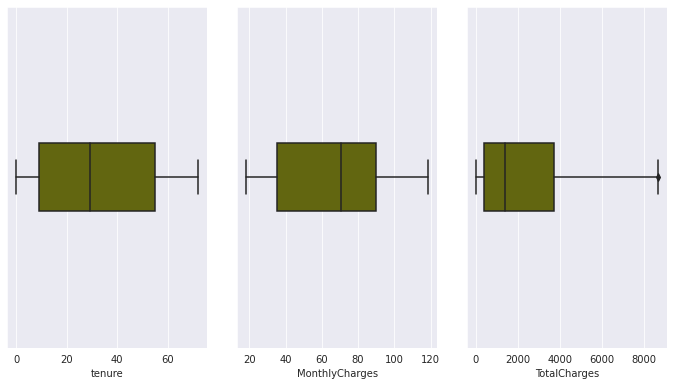

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,6))
for i, c in enumerate(train_X[num]):
    sea.boxplot(train_X[c], orient="v", color = "#6f7501",
                                width = 0.2, ax=axes[i])
    
fig.tight_layout(pad=3.0)

There are no outliers as can be seen from the box plots.

## Visualization

Categorical features.

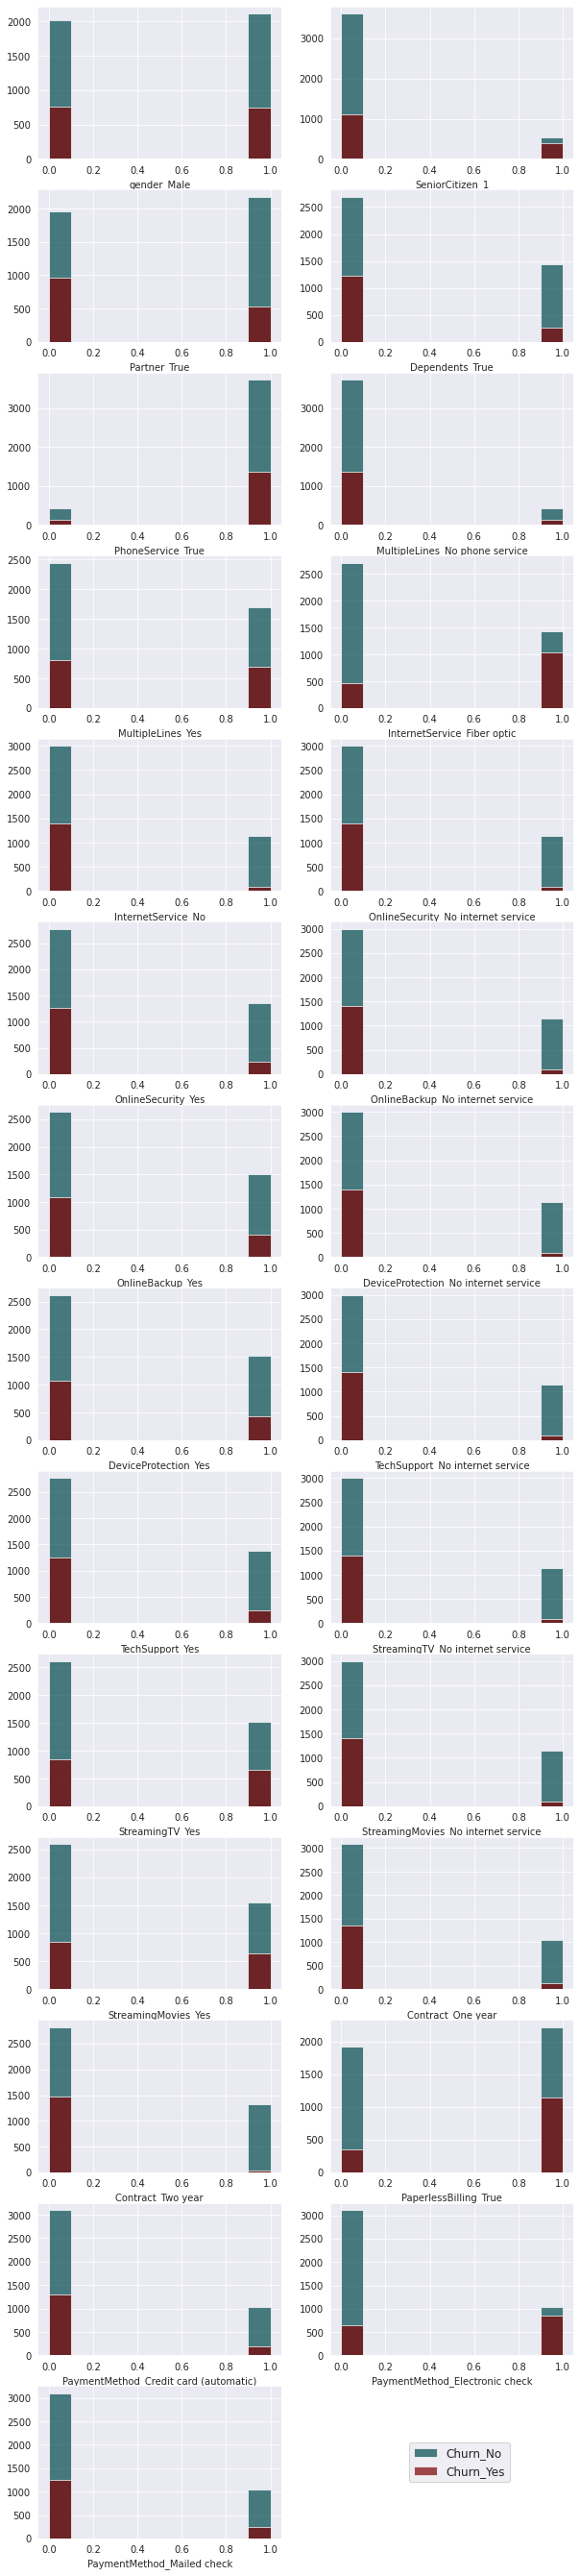

In [ ]:
fig = plt.figure(figsize=(10,66))
gs = gridspec.GridSpec(nrows=19, ncols=2, figure=fig)

for i, c in enumerate(train_X[cat2]):
    y, x = np.int(i/2), i%2 
    ax = fig.add_subplot(gs[y,x])    
    sea.distplot(train_X.loc[train_Y["Churn"]==0,c], kde = False,
                 color = "#004a4d", hist_kws = dict(alpha=0.7),
                 bins=10, label="Churn_No", ax=ax);
    sea.distplot(train_X.loc[train_Y["Churn"]==1,c], kde = False,
                 color = "#7d0101", hist_kws = dict(alpha=0.7),
                 bins=10, label="Churn_Yes", ax=ax);

ax.legend(loc="center left", bbox_to_anchor=(1.5,0.5),
          prop={"size":12});

Numerical features.

In [ ]:
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)

for i, c in enumerate(train_X[num]):
    y, x = np.int(i/2), i%2 
    ax = fig.add_subplot(gs[y,x])    
    sea.distplot(train_X.loc[train_Y["Churn"]==0,c], kde = True,
                 color = "#004a4d", hist_kws = dict(alpha=0.8),
                 bins=20, label="Churn_No", ax=ax);
    sea.distplot(train_X.loc[train_Y["Churn"]==1,c], kde = True,
                 color = "#7d0101", hist_kws = dict(alpha=0.5),
                 bins=20, label="Churn_Yes", ax=ax);

ax.legend(loc="center left", bbox_to_anchor=(1.5,0.5),
          prop={"size":12});

## Standardization

StandardScaler is only fit to training data to prevent data leakage.

In [ ]:
scaler = StandardScaler()

# fit to train_X
scaler.fit(train_X)

# transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

# transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

## Correlation analysis

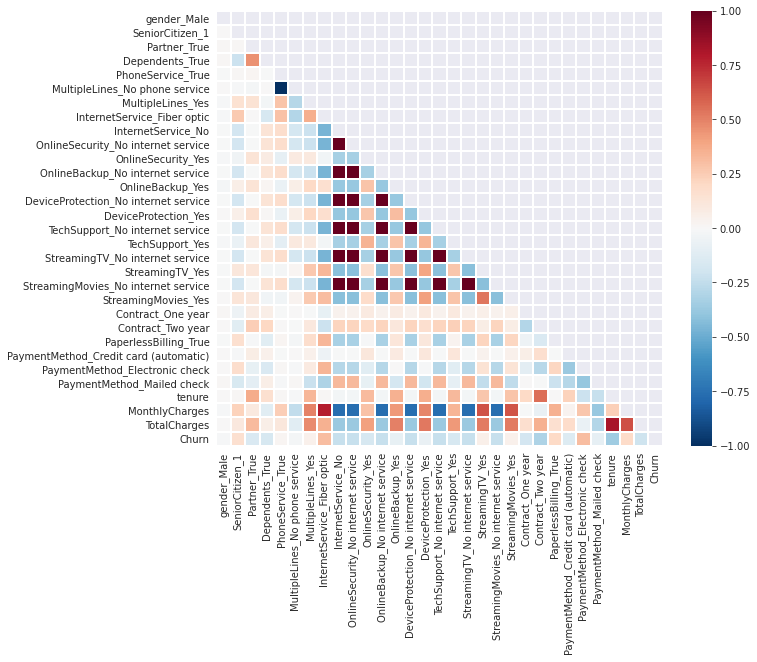

In [ ]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=False, fmt=".1f", vmin=-1,
            vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

Some features are dropped due to high correlation. Then, dataframes are converted to numpy arrays.

In [ ]:
drop = ["OnlineSecurity_No internet service",
        "OnlineBackup_No internet service",
        "DeviceProtection_No internet service",
        "TechSupport_No internet service",
        "StreamingTV_No internet service",
        "StreamingMovies_No internet service",
        "MultipleLines_No phone service"]

for d in drop:
    train_X.drop(d, axis=1, inplace=True)
    test_X.drop(d, axis=1, inplace=True)
    
np_train_X = train_X.values
np_train_Y = train_Y.values.ravel()
np_test_X = test_X.values
np_test_Y = test_Y.values.ravel()

## KNN with Brute NN Search

We will try KNN first with brute nearest neighbor search. We use grid search to find the optimal parameters and use stratified 5-fold for cross validation. Minkowski is used as distance metric and its value is searched (1 or 2). When p equals 1, Minkowski is Manhattan distance and when p equals 2, it is Euclidean distance. During grid search, model performance with each parameter combination is measured on cross validation folds. The parameters giving the highest performance is returned as best parameter set.

In [ ]:
knn_cls = KNeighborsClassifier()
parameters = {
    "n_neighbors": range(30, 50, 2),
    "metric": ["minkowski"],
    "p": [1.0, 2.0],
    "algorithm": ["brute"]
}

skf_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
gscv = GridSearchCV(
    estimator=knn_cls,
    param_grid=parameters,
    scoring="f1",
    n_jobs=-1,
    cv=skf_cv,
    verbose=False
)

gscv.fit(np_train_X, np_train_Y)
print("Best parameters {}".format(gscv.best_params_))

Best parameters {'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 38, 'p': 1.0}


We train a new KNeighborsClassifier with the best parameters on np_train_X. Then we make predictions on np_test_X.

In [ ]:
knn_cls = KNeighborsClassifier(**gscv.best_params_)
knn_cls.fit(np_train_X, np_train_Y)
y_pred = knn_cls.predict(np_test_X)
print(classification_report(np_test_Y, y_pred,
                            target_names=["Churn No", "Churn Yes"]))

              precision    recall  f1-score   support

    Churn No       0.84      0.89      0.87      1035
   Churn Yes       0.64      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



## KNN with KDTree

In nearest neighbor search, data structures like kdtree can be incorporated instead of using KNN in its original form with brute search. kdtree learns which training sample is residing on which part of the feature space. On inference, it takes you to the close proximity of test sample and gives you the neighbors. kdtree allows you to search multidimensional space efficiently.

When creating kdtree, each node splits data using 1 dimension (1 feature). The split point is determined as the median of points along that dimension. The seperating hyperplane is orthogonal to dimension axis. The points on the left of hyperplane go to left child, the points on the right go to right child node. Choosing the number of points on each leaf, we slice the space into subspaces with the resolution we want. When a leaf is reached, we get a number of training points that we are interested in and KNeighborsClassifier switches to brute nearest neighbor search on this set.

Below, we do another grid search with KNeighborsClassifier to find optimal K, Minkowski p value when algorithm parameter is set to kd_tree. This time we have an extra hyperparameter, leaf_size denotes the number of points in each leaf.

In [ ]:
knn_cls = KNeighborsClassifier()
parameters = {
    "n_neighbors": range(40, 60, 2),
    "leaf_size": [1, 2, 3],
    "metric": ["minkowski"],
    "p": [1.0, 2.0],
    "algorithm": ["kd_tree"]
}

skf_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
gscv = GridSearchCV(
    estimator=knn_cls,
    param_grid=parameters,
    scoring="f1",
    n_jobs=-1,
    cv=skf_cv,
    verbose=False
)

gscv.fit(np_train_X, np_train_Y)
print("Best parameters {}".format(gscv.best_params_))

Best parameters {'algorithm': 'kd_tree', 'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 54, 'p': 1.0}


We train a new KNeighborsClassifier with the best parameters on np_train_X. Then we make predictions on np_test_X.

In [ ]:
knn_cls = KNeighborsClassifier(**gscv.best_params_)
knn_cls.fit(np_train_X, np_train_Y)
y_pred = knn_cls.predict(np_test_X)
print(classification_report(np_test_Y, y_pred,
                            target_names=["Churn No", "Churn Yes"]))

              precision    recall  f1-score   support

    Churn No       0.83      0.89      0.86      1035
   Churn Yes       0.63      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

